In [3]:
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
import pandas as pd
import math
import numpy as np
import re
import numpy as np
import nltk.corpus
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
from numpy.linalg import norm
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly_express as px
import seaborn as sns

# Final Project Code

# Parsed and Annotated Data

## LIB

In [4]:
speeches = pd.read_csv('C:/Users/bigja/OneDrive/Documents/DS5001/data/presidential_speeches/presidential_speeches.csv')

In [5]:
speeches = speeches.reset_index(drop=False).rename(columns={'index': 'speech_id'})


In [6]:
speeches = speeches.dropna(subset=['Transcript'])

In [67]:
len(speeches['Transcript'])

991

In [8]:
LIB = pd.DataFrame(speeches, columns=['speech_id','Date','President','Party', 'Speech Title'])\
    .set_index('speech_id').sort_index()

In [9]:
LIB.to_csv('LIB.csv')

In [10]:

math.ceil(np.mean(([len(i) for i in speeches.Transcript])))

22523

## CORPUS

In [11]:

corpus_data = []
def clean_text(text):
    # Remove digits and replace multiple white spaces with a single space
    return re.sub(r'\d+', '', text).strip()

# Process each speech
for speech_id, text in enumerate(speeches['Transcript'], start=0):  # Starting speech_id from 0
    sentences = sent_tokenize(text)
    
    for sent_num, sentence in enumerate(sentences):
        tokens = word_tokenize(sentence)
        tagged_tokens = pos_tag(tokens)
        
        for token_num, (token, pos) in enumerate(tagged_tokens):
            term_str = clean_text(token.lower())
            token_str_clean = clean_text(token)
            pos_tuple_clean = clean_text(str((token, pos)))
            
            corpus_data.append({
                'speech_id': speech_id,
                'sent_num': sent_num,
                'token_num': token_num,
                'pos_tuple': pos_tuple_clean,
                'pos': pos,
                'token_str': token_str_clean,
                'term_str': term_str,
                'pos_group': pos[:2]  # Using first two letters as POS group
            })

# Convert the list of dictionaries to a DataFrame
CORPUS = pd.DataFrame(corpus_data)

# Display the DataFrame to verify
print(CORPUS.head())

   speech_id  sent_num  token_num             pos_tuple   pos token_str  \
0          0         0          0     ('Fellow', 'NNP')   NNP    Fellow   
1          0         0          1  ('Citizens', 'NNPS')  NNPS  Citizens   
2          0         0          2          ('of', 'IN')    IN        of   
3          0         0          3         ('the', 'DT')    DT       the   
4          0         0          4     ('Senate', 'NNP')   NNP    Senate   

   term_str pos_group  
0    fellow        NN  
1  citizens        NN  
2        of        IN  
3       the        DT  
4    senate        NN  


In [12]:
# Initialize an empty list to collect data
corpus_data = []

# Process each speech
for speech_id, text in enumerate(speeches['Transcript'], start=0):  # Starting speech_id from 1
    sentences = sent_tokenize(text)
    
    for sent_num, sentence in enumerate(sentences):
        tokens = word_tokenize(sentence)
        tagged_tokens = pos_tag(tokens)
        
        for token_num, (token, pos) in enumerate(tagged_tokens):
            term_str = token.lower()
            
            corpus_data.append({
                'speech_id': speech_id,
                'sent_num': sent_num,
                'token_num': token_num,
                'pos_tuple': str((token, pos)),
                'pos': pos,
                'token_str': token,
                'term_str': term_str,
                'pos_group': pos[:2]  # Using first letter as POS group
            })

# Convert the list of dictionaries to a DataFrame
CORPUS= pd.DataFrame(corpus_data)



In [13]:
punc_pos = ['$', "''", '(', ')', ',', '--', '.', ':', '``']
CORPUS['term_str'] = CORPUS[~CORPUS.pos.isin(punc_pos)].token_str\
                    .str.replace(r'[\W_]+', '', regex=True).str.lower()  
CORPUS = CORPUS.dropna(subset='term_str').reset_index(drop=True)


In [14]:
CORPUS


speech_id  sent_num  token_num             pos_tuple   pos token_str  \
0                0         0          0     ('Fellow', 'NNP')   NNP    Fellow   
1                0         0          1  ('Citizens', 'NNPS')  NNPS  Citizens   
2                0         0          2          ('of', 'IN')    IN        of   
3                0         0          3         ('the', 'DT')    DT       the   
4                0         0          4     ('Senate', 'NNP')   NNP    Senate   
...            ...       ...        ...                   ...   ...       ...   
3838302        990       547          1        ('you', 'PRP')   PRP       you   
3838303        990       548          0      ('Thank', 'NNP')   NNP     Thank   
3838304        990       548          1        ('you', 'PRP')   PRP       you   
3838305        990       548          2        ('very', 'RB')    RB      very   
3838306        990       548          3        ('much', 'RB')    RB      much   

         term_str pos_group  
0          fellow        NN  
1        citizens        NN  
2              of        IN  
3             the        DT  
4          senate        NN  
...           ...       ...  
3838302       you        PR  
3838303     thank        NN  
3838304       you        PR  
3838305      very        RB  
3838306      much        RB  

[3838307 rows x 8 columns]

In [15]:
CORPUS.to_csv('CORPUS.csv')

## VOCAB

In [62]:


VOCAB = CORPUS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)
VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)
TPM = CORPUS[['term_str','pos']].value_counts().unstack()
VOCAB['n_pos'] = TPM.count(1)
VOCAB['cat_pos'] = CORPUS[['term_str','pos']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos.apply(lambda x: set(x))
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)

VOCAB['max_pos_group'] = CORPUS[['term_str','pos_group']].value_counts().unstack(fill_value=0).idxmax(1)



In [63]:
VOCAB

n  n_chars             p          i max_pos  n_pos  \
term_str                                                              
             11810        0  3.076877e-03   8.344317     NNP     33   
0                8        1  2.084252e-06  18.872039      CD      1   
000              3        3  7.815946e-07  20.287076      CD      1   
000000           1        6  2.605315e-07  21.872039      CD      1   
007              1        3  2.605315e-07  21.872039      CD      1   
...            ...      ...           ...        ...     ...    ...   
zooming          1        7  2.605315e-07  21.872039     VBG      1   
zootsuiters      1       11  2.605315e-07  21.872039     NNS      1   
zte              2        3  5.210631e-07  20.872039     NNP      1   
zuckert          1        7  2.605315e-07  21.872039     NNP      1   
zuloaga          5        7  1.302658e-06  19.550111     NNP      1   

                                                       cat_pos  stop  \
term_str                                                               
             {CC, NNPS, WP, EX, NN, MD, VB, FW, DT, RBR, WR...     0   
0                                                         {CD}     0   
000                                                       {CD}     0   
000000                                                    {CD}     0   
007                                                       {CD}     0   
...                                                        ...   ...   
zooming                                                  {VBG}     0   
zootsuiters                                              {NNS}     0   
zte                                                      {NNP}     0   
zuckert                                                  {NNP}     0   
zuloaga                                                  {NNP}     0   

            stem_porter stem_snowball stem_lancaster max_pos_group  
term_str                                                            
                                                                NN  
0                     0             0              0            CD  
000                 000           000            000            CD  
000000           000000        000000         000000            CD  
007                 007           007            007            CD  
...                 ...           ...            ...           ...  
zooming            zoom          zoom           zoom            VB  
zootsuiters    zootsuit      zootsuit       zootsuit            NN  
zte                 zte           zte            zte            NN  
zuckert         zuckert       zuckert        zuckert            NN  
zuloaga         zuloaga       zuloaga         zuloag            NN  

[43537 rows x 12 columns]

In [19]:

def create_bow(CORPUS, bag, item_type='term_str'):
    BOW = CORPUS.groupby(bag+[item_type])[item_type].count().to_frame('n')
    return BOW

BOW = create_bow(CORPUS, bag=['speech_id'])


In [20]:
BOW
DTM = BOW.n.unstack(fill_value=0)

term_str      0  000  000000  007  01  0111  013  018249  02  ...  zollverein  \
speech_id                                                     ...               
0          2  0    0       0    0   0     0    0       0   0  ...           0   
1          2  0    0       0    0   0     0    0       0   0  ...           0   
2          0  0    0       0    0   0     0    0       0   0  ...           0   
3          2  0    0       0    0   0     0    0       0   0  ...           0   
4          8  0    0       0    0   0     0    0       0   0  ...           0   

term_str   zone  zones  zoning  zoological  zooming  zootsuiters  zte  \
speech_id                                                               
0             0      0       0           0        0            0    0   
1             0      0       0           0        0            0    0   
2             0      0       0           0        0            0    0   
3             0      0       0           0        0            0    0   
4             0      0       0           0        0            0    0   

term_str   zuckert  zuloaga  
speech_id                    
0                0        0  
1                0        0  
2                0        0  
3                0        0  
4                0        0  

[5 rows x 43537 columns]

In [21]:
BOW

n
speech_id term_str         
0                         2
          a              15
          accomplished    1
          accordingly     1
          acknowledge     1
...                     ...
990       you           136
          young           1
          your            9
          yourself        1
          zealand         1

[941286 rows x 1 columns]

In [22]:
def get_tfidf(BOW, tf_method='max', df_method='standard', item_type='term_str'):
            
    DTCM = BOW.n.unstack() # Create Doc-Term Count Matrix
    
    if tf_method == 'sum':
        TF = (DTCM.T / DTCM.T.sum()).T
    elif tf_method == 'max':
        TF = (DTCM.T / DTCM.T.max()).T
    elif tf_method == 'log':
        TF = (np.log2(DTCM.T + 1)).T
    elif tf_method == 'raw':
        TF = DTCM
    elif tf_method == 'bool':
        TF = DTCM.astype('bool').astype('int')
    else:
        raise ValueError(f"TF method {tf_method} not found.")

    DF = DTCM.count()
    N_docs = len(DTCM)
    
    if df_method == 'standard':
        IDF = np.log2(N_docs/DF) 
    elif df_method == 'textbook':
        IDF = np.log2(N_docs/(DF + 1))
    elif df_method == 'sklearn':
        IDF = np.log2(N_docs/DF) + 1
    elif df_method == 'sklearn_smooth':
        IDF = np.log2((N_docs + 1)/(DF + 1)) + 1
    else:
        raise ValueError(f"DF method {df_method} not found.")
    
    TFIDF = TF * IDF
    
    DFIDF = DF * IDF
    
    TFIDF = TFIDF.fillna(0)

    return TFIDF, DFIDF

In [65]:
TFIDF, DFIDF = get_tfidf(BOW)

VOCAB['dfidf'] = DFIDF

VOCAB.dfidf.sort_values(ascending=False).head(20)



term_str
nearly          525.960837
away            525.960837
used            525.960837
though          525.960565
terms           525.960565
lead            525.957156
party           525.956330
self            525.949533
independence    525.949533
seek            525.949533
held            525.949533
including       525.948120
feel            525.948120
fair            525.948120
experience      525.948120
forward         525.948120
regard          525.948120
going           525.948120
entire          525.937979
sure            525.937979
Name: dfidf, dtype: float64

In [66]:
VOCAB.to_csv('VOCAB.csv')

In [24]:
VOCAB.head()

n  n_chars             p          i max_pos  n_pos  \
term_str                                                           
          11810        0  3.076877e-03   8.344317     NNP     33   
0             8        1  2.084252e-06  18.872039      CD      1   
000           3        3  7.815946e-07  20.287076      CD      1   
000000        1        6  2.605315e-07  21.872039      CD      1   
007           1        3  2.605315e-07  21.872039      CD      1   

                                                    cat_pos  stop stem_porter  \
term_str                                                                        
          {CC, NNPS, WP, EX, NN, MD, VB, FW, DT, RBR, WR...     0               
0                                                      {CD}     0           0   
000                                                    {CD}     0         000   
000000                                                 {CD}     0      000000   
007                                                    {CD}     0         007   

         stem_snowball stem_lancaster       dfidf  
term_str                                           
                                       275.970854  
0                    0              0   31.810965  
000                000            000   17.905482  
000000          000000         000000    9.952741  
007                007            007    9.952741

In [25]:
VOCAB.to_csv('VOCAB.csv')

# Derived Tables

## BOW

In [26]:
BOW['tfidf'] = TFIDF.stack()

In [27]:
BOW

n     tfidf
speech_id term_str                   
0                         2  0.006095
          a              15  0.000561
          accomplished    1  0.017435
          accordingly     1  0.026884
          acknowledge     1  0.032679
...                     ...       ...
990       you           136  0.263528
          young           1  0.006852
          your            9  0.022463
          yourself        1  0.018704
          zealand         1  0.022700

[941286 rows x 2 columns]

In [28]:
BOW.to_csv('BOW.csv')

## DTM

In [29]:
DTM.to_csv('DTM.csv')

## TFIDF

In [30]:
TFIDF.to_csv('TFIDF.csv')

## Reduced and Normalized TFIDF_L2

In [31]:

M = TFIDF[VOCAB].fillna(0).groupby('speech_id').mean()
M


term_str          0  000  000000  007   01  0111  013  018249   02  ...  \
speech_id                                                           ...   
0          0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0     0.0  0.0  ...   
1          0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0     0.0  0.0  ...   
2          0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0     0.0  0.0  ...   
3          0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0     0.0  0.0  ...   
4          0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0     0.0  0.0  ...   
...        ...  ...  ...     ...  ...  ...   ...  ...     ...  ...  ...   
986        0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0     0.0  0.0  ...   
987        0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0     0.0  0.0  ...   
988        0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0     0.0  0.0  ...   
989        0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0     0.0  0.0  ...   
990        0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0     0.0  0.0  ...   

term_str   zollverein  zone  zones  zoning  zoological  zooming  zootsuiters  \
speech_id                                                                      
0                 0.0   0.0    0.0     0.0         0.0      0.0          0.0   
1                 0.0   0.0    0.0     0.0         0.0      0.0          0.0   
2                 0.0   0.0    0.0     0.0         0.0      0.0          0.0   
3                 0.0   0.0    0.0     0.0         0.0      0.0          0.0   
4                 0.0   0.0    0.0     0.0         0.0      0.0          0.0   
...               ...   ...    ...     ...         ...      ...          ...   
986               0.0   0.0    0.0     0.0         0.0      0.0          0.0   
987               0.0   0.0    0.0     0.0         0.0      0.0          0.0   
988               0.0   0.0    0.0     0.0         0.0      0.0          0.0   
989               0.0   0.0    0.0     0.0         0.0      0.0          0.0   
990               0.0   0.0    0.0     0.0         0.0      0.0          0.0   

term_str   zte  zuckert  zuloaga  
speech_id                         
0          0.0      0.0      0.0  
1          0.0      0.0      0.0  
2          0.0      0.0      0.0  
3          0.0      0.0      0.0  
4          0.0      0.0      0.0  
...        ...      ...      ...  
986        0.0      0.0      0.0  
987        0.0      0.0      0.0  
988        0.0      0.0      0.0  
989        0.0      0.0      0.0  
990        0.0      0.0      0.0  

[991 rows x 43537 columns]

In [32]:
VSHORT = VOCAB[VOCAB.max_pos.isin(['NN', 'VB', 'JJ']) & ~VOCAB.max_pos.isin(['NNP'])].sort_values('dfidf', ascending=False).head(5000)
TFIDF = TFIDF[VSHORT.index]

L2 = (TFIDF.T / norm(TFIDF, 2, axis=1)).T

L2

term_str       lead     party      self  independence      seek  experience  \
speech_id                                                                     
0          0.000000  0.025650  0.000000      0.000000  0.000000     0.02572   
1          0.000000  0.000000  0.000000      0.000000  0.000000     0.00000   
2          0.000000  0.000000  0.000000      0.000000  0.000000     0.00000   
3          0.027536  0.000000  0.000000      0.000000  0.000000     0.00000   
4          0.027270  0.000000  0.000000      0.000000  0.000000     0.00000   
...             ...       ...       ...           ...       ...         ...   
986        0.000000  0.000000  0.000000      0.000000  0.000000     0.00000   
987        0.008901  0.008975  0.000000      0.008877  0.000000     0.00000   
988        0.000000  0.005448  0.000000      0.000000  0.000000     0.00000   
989        0.000000  0.000000  0.024181      0.012091  0.048362     0.00000   
990        0.000000  0.000000  0.000000      0.000000  0.000000     0.00000   

term_str     regard      fair      sure    entire  ...  robust  conduce  \
speech_id                                          ...                    
0          0.025720  0.000000  0.000000  0.025301  ...     0.0      0.0   
1          0.000000  0.000000  0.000000  0.000000  ...     0.0      0.0   
2          0.111425  0.000000  0.000000  0.000000  ...     0.0      0.0   
3          0.000000  0.000000  0.000000  0.000000  ...     0.0      0.0   
4          0.000000  0.000000  0.027120  0.000000  ...     0.0      0.0   
...             ...       ...       ...       ...  ...     ...      ...   
986        0.000000  0.013645  0.000000  0.000000  ...     0.0      0.0   
987        0.000000  0.017999  0.008852  0.026557  ...     0.0      0.0   
988        0.000000  0.010927  0.000000  0.000000  ...     0.0      0.0   
989        0.000000  0.024515  0.000000  0.000000  ...     0.0      0.0   
990        0.000000  0.016000  0.000000  0.000000  ...     0.0      0.0   

term_str   hoard  sequel  deaf  taxfree  hindrance  tempt  insuperable  \
speech_id                                                                
0            0.0     0.0   0.0      0.0        0.0    0.0          0.0   
1            0.0     0.0   0.0      0.0        0.0    0.0          0.0   
2            0.0     0.0   0.0      0.0        0.0    0.0          0.0   
3            0.0     0.0   0.0      0.0        0.0    0.0          0.0   
4            0.0     0.0   0.0      0.0        0.0    0.0          0.0   
...          ...     ...   ...      ...        ...    ...          ...   
986          0.0     0.0   0.0      0.0        0.0    0.0          0.0   
987          0.0     0.0   0.0      0.0        0.0    0.0          0.0   
988          0.0     0.0   0.0      0.0        0.0    0.0          0.0   
989          0.0     0.0   0.0      0.0        0.0    0.0          0.0   
990          0.0     0.0   0.0      0.0        0.0    0.0          0.0   

term_str   indignant  
speech_id             
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  
...              ...  
986              0.0  
987              0.0  
988              0.0  
989              0.0  
990              0.0  

[991 rows x 5000 columns]

In [33]:
L2.to_csv('Reduced_and_Normalized_TFIDF_L2.csv')

In [34]:
L2.head()

term_str       lead    party  self  independence  seek  experience    regard  \
speech_id                                                                      
0          0.000000  0.02565   0.0           0.0   0.0     0.02572  0.025720   
1          0.000000  0.00000   0.0           0.0   0.0     0.00000  0.000000   
2          0.000000  0.00000   0.0           0.0   0.0     0.00000  0.111425   
3          0.027536  0.00000   0.0           0.0   0.0     0.00000  0.000000   
4          0.027270  0.00000   0.0           0.0   0.0     0.00000  0.000000   

term_str   fair     sure    entire  ...  robust  conduce  hoard  sequel  deaf  \
speech_id                           ...                                         
0           0.0  0.00000  0.025301  ...     0.0      0.0    0.0     0.0   0.0   
1           0.0  0.00000  0.000000  ...     0.0      0.0    0.0     0.0   0.0   
2           0.0  0.00000  0.000000  ...     0.0      0.0    0.0     0.0   0.0   
3           0.0  0.00000  0.000000  ...     0.0      0.0    0.0     0.0   0.0   
4           0.0  0.02712  0.000000  ...     0.0      0.0    0.0     0.0   0.0   

term_str   taxfree  hindrance  tempt  insuperable  indignant  
speech_id                                                     
0              0.0        0.0    0.0          0.0        0.0  
1              0.0        0.0    0.0          0.0        0.0  
2              0.0        0.0    0.0          0.0        0.0  
3              0.0        0.0    0.0          0.0        0.0  
4              0.0        0.0    0.0          0.0        0.0  

[5 rows x 5000 columns]

# Models

## PCA Components

In [35]:
def get_pca(TFIDF, 
            k=10, 
            norm_docs=True,
            norm_level=2,
            center_by_mean=True, 
            center_by_variance=False):
    
    # if TFIDF.isna().sum().sum():
    #     print("Filled NA")
    #     TFIDF = TFIDF.fillna(0)
    
    if norm_docs:
        # TFIDF = TFIDF.apply(lambda x: x / norm(x), 1).fillna(0)
        TFIDF = (TFIDF.T / norm(TFIDF, 2, axis=1)).T
    
    if center_by_mean:
        TFIDF = TFIDF - TFIDF.mean()
        
    if center_by_variance:
        TFIDF = TFIDF / TFIDF.std()        

    COV = TFIDF.cov()

    eig_vals, eig_vecs = eigh(COV)
    
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'
        
    EIG_IDX = EIG_VAL.eig_val.sort_values(ascending=False).head(k)
    
    COMPS = EIG_VEC[EIG_IDX.index].T
    COMPS.index = [i for i in range(COMPS.shape[0])]
    COMPS.index.name = 'pc_id'
    

    LOADINGS = COMPS.T

    DCM = TFIDF.dot(LOADINGS)
    
    COMPINF = pd.DataFrame(index=COMPS.index)

    for i in range(k):
        for j in [0, 1]:
            top_terms = ' '.join(LOADINGS.sort_values(i, ascending=bool(j)).head(5).index.to_list())
            COMPINF.loc[i, j] = top_terms
    COMPINF = COMPINF.rename(columns={0:'pos', 1:'neg'})
    
    COMPINF['eig_val'] = EIG_IDX.reset_index(drop=True).to_frame()
    COMPINF['exp_var'] = COMPINF.eig_val / COMPINF.eig_val.sum()
    
    return LOADINGS, DCM, COMPINF

In [36]:
center_by_mean= False 
center_by_variance = False

In [37]:
pca_engine = PCA(n_components=10)


In [38]:
LIB.head()

Date          President         Party  \
speech_id                                                
0          1789-04-30  George Washington  Unaffiliated   
1          1789-10-03  George Washington  Unaffiliated   
2          1790-01-08  George Washington  Unaffiliated   
3          1790-12-08  George Washington  Unaffiliated   
4          1790-12-29  George Washington  Unaffiliated   

                                                Speech Title  
speech_id                                                     
0                                    First Inaugural Address  
1                                  Thanksgiving Proclamation  
2                           First Annual Message to Congress  
3                          Second Annual Message to Congress  
4          Talk to the Chiefs and Counselors of the Senec...

## PCA DCM

In [39]:
DCM = pd.DataFrame(pca_engine.fit_transform(L2.fillna(0)), index=L2.index)
DCM.columns = ['PC{}'.format(i) for i in DCM.columns]
DCM = DCM.join(LIB[['President','Speech Title']], on='speech_id')

In [40]:
DCM

PC0       PC1       PC2       PC3       PC4       PC5  \
speech_id                                                               
0          0.075437 -0.111161 -0.013185 -0.052151 -0.109391 -0.005907   
1          0.040410 -0.170519  0.037840 -0.019863 -0.066951  0.012504   
2          0.158526 -0.070595 -0.014122 -0.069820 -0.060783  0.007817   
3          0.188899 -0.043041 -0.003100 -0.094147 -0.011437 -0.003660   
4          0.060360 -0.119389  0.021572 -0.079512  0.022765  0.030966   
...             ...       ...       ...       ...       ...       ...   
986       -0.107346 -0.056426  0.092428 -0.035448 -0.017059  0.066053   
987       -0.248768  0.099527 -0.005999 -0.143560 -0.032442  0.075196   
988       -0.193152  0.030198  0.178134 -0.070838  0.005023 -0.107224   
989       -0.192834  0.063626 -0.175607 -0.039606 -0.053737  0.096544   
990       -0.179746  0.013087  0.141117 -0.053121  0.007188 -0.112885   

                PC6       PC7       PC8       PC9          President  \
speech_id                                                              
0          0.087444 -0.082581  0.056002  0.021746  George Washington   
1          0.070003 -0.044829  0.043267 -0.002372  George Washington   
2          0.077246 -0.074907  0.087053 -0.054411  George Washington   
3          0.103126 -0.086538  0.093307 -0.097428  George Washington   
4         -0.010810 -0.077859 -0.043596  0.033124  George Washington   
...             ...       ...       ...       ...                ...   
986       -0.105700 -0.015376 -0.087000 -0.026863       Donald Trump   
987       -0.146014  0.081064 -0.076316 -0.019808       Donald Trump   
988       -0.192820 -0.187199 -0.101869 -0.029128       Donald Trump   
989       -0.024664  0.081636 -0.054562  0.058173       Donald Trump   
990       -0.154769 -0.196799 -0.076343 -0.019773       Donald Trump   

                                                Speech Title  
speech_id                                                     
0                                    First Inaugural Address  
1                                  Thanksgiving Proclamation  
2                           First Annual Message to Congress  
3                          Second Annual Message to Congress  
4          Talk to the Chiefs and Counselors of the Senec...  
...                                                      ...  
986        Address at the 73rd Session of the United Nati...  
987                     Remarks about the US Southern Border  
988                               State of the Union Address  
989                    Speech Declaring a National Emergency  
990           Remarks at the United Nations General Assembly  

[991 rows x 12 columns]

In [41]:
DCM.to_csv('DCM_PCA.csv')

## PCA Loadings

In [42]:
LOADINGS = pd.DataFrame(pca_engine.components_.T * np.sqrt(pca_engine.explained_variance_))
LOADINGS.columns = ["PC{}".format(i) for i in LOADINGS.columns]
LOADINGS.index = L2.columns
LOADINGS.index.name = 'term_str'

In [43]:
LOADINGS.to_csv('PCA_LOADINGS.csv')

In [44]:
compinf=pd.DataFrame()

for i in range(10):
    top_positive_terms = LOADINGS.iloc[:, i].nlargest(5).index.tolist()
    top_negative_terms = LOADINGS.iloc[:, i].nsmallest(5).index.tolist()
    compinf.loc[i, 'Top 5 Positive Terms'] = ', '.join(top_positive_terms)
    compinf.loc[i, 'Top 5 Negative Terms'] = ', '.join(top_negative_terms)

# Add eigenvalues and explained variance to the COMPINF table
compinf['Eigenvalue'] = pca_engine.explained_variance_
compinf['Explained Variance Ratio'] = pca_engine.explained_variance_ratio_

compinf.index.name = 'Component'


In [45]:
compinf.to_csv('PCA_COMPONENTS.csv')

In [46]:
top_5_positive_first = LOADINGS['PC0'].nlargest(5).index.tolist()

# Top 5 negative terms for the second principal component (PC1)
top_5_negative_second = LOADINGS['PC1'].nsmallest(5).index.tolist()

print("Top 5 positive terms for the first component:", top_5_positive_first)
print("Top 5 negative terms for the second component:", top_5_negative_second)


Top 5 positive terms for the first component: ['treaty', 'subject', 'revenue', 'commerce', 'public']
Top 5 negative terms for the second component: ['proclamation', 'aforesaid', 'whereof', 'seal', 'thereof']


In [47]:
DOC = pd.DataFrame(index=L2.index).join(LIB)

In [48]:
DOC

Date          President         Party  \
speech_id                                                
0          1789-04-30  George Washington  Unaffiliated   
1          1789-10-03  George Washington  Unaffiliated   
2          1790-01-08  George Washington  Unaffiliated   
3          1790-12-08  George Washington  Unaffiliated   
4          1790-12-29  George Washington  Unaffiliated   
...               ...                ...           ...   
986        2018-09-25       Donald Trump    Republican   
987        2019-01-19       Donald Trump    Republican   
988        2019-02-05       Donald Trump    Republican   
989        2019-02-15       Donald Trump    Republican   
990        2019-09-24       Donald Trump    Republican   

                                                Speech Title  
speech_id                                                     
0                                    First Inaugural Address  
1                                  Thanksgiving Proclamation  
2                           First Annual Message to Congress  
3                          Second Annual Message to Congress  
4          Talk to the Chiefs and Counselors of the Senec...  
...                                                      ...  
986        Address at the 73rd Session of the United Nati...  
987                     Remarks about the US Southern Border  
988                               State of the Union Address  
989                    Speech Declaring a National Emergency  
990           Remarks at the United Nations General Assembly  

[991 rows x 4 columns]

In [49]:
DOC['label'] = DOC.apply(lambda x: f"{x.Date}-{x.President}-{x['Speech Title']}", 1)


In [50]:
DOC= DOC.reset_index()

## PCA Visualization 1

In [52]:
px.scatter(DCM, 'PC0', 'PC1', 
           color=DOC.Party, 
           hover_name=DOC.label, 
           marginal_x='box', marginal_y='box', height=1000)

In [55]:
VSHORT['df'] = DTM.astype('bool').sum()


In [56]:
VSHORT

n  n_chars         p          i max_pos  n_pos  \
term_str                                                          
lead           685        4  0.000178  12.452078      VB      6   
party         1201        5  0.000313  11.642018      NN      2   
self           869        4  0.000226  12.108826      JJ     11   
independence   860       12  0.000224  12.123846      NN      3   
seek           793        4  0.000207  12.240862      VB      7   
...            ...      ...       ...        ...     ...    ...   
taxfree         13        7  0.000003  18.171599      JJ      2   
hindrance       11        9  0.000003  18.412607      NN      1   
tempt           11        5  0.000003  18.412607      VB      2   
insuperable     13       11  0.000003  18.171599      JJ      1   
indignant       11        9  0.000003  18.412607      JJ      2   

                                                        cat_pos  stop  \
term_str                                                                
lead                                {NN, VB, VBP, JJ, VBD, VBN}     0   
party                                                 {NNP, NN}     0   
self          {PRP, RB, NN, NNP, VB, VBP, JJ, VBD, FW, VBN, ...     0   
independence                                      {NNP, VB, NN}     0   
seek                           {NN, NNP, VB, VBP, JJ, VBD, VBZ}     0   
...                                                         ...   ...   
taxfree                                                {JJ, NN}     0   
hindrance                                                  {NN}     0   
tempt                                                  {VB, NN}     0   
insuperable                                                {JJ}     0   
indignant                                              {JJ, NN}     0   

             stem_porter stem_snowball stem_lancaster       dfidf   df  
term_str                                                                
lead                lead          lead           lead  525.957156  366  
party              parti         parti          party  525.956330  363  
self                self          self           self  525.949533  367  
independence    independ      independ       independ  525.949533  367  
seek                seek          seek           seek  525.949533  367  
...                  ...           ...            ...         ...  ...  
taxfree           taxfre        taxfre          taxfr   71.426406   11  
hindrance       hindranc      hindranc          hindr   71.426406   11  
tempt              tempt         tempt          tempt   71.426406   11  
insuperable      insuper       insuper          insup   71.426406   11  
indignant         indign        indign         indign   71.426406   11  

[5000 rows x 13 columns]

In [69]:
px.scatter(LOADINGS.join(VSHORT).reset_index(), 'PC0', 'PC1', hover_name='term_str', 
           size='df', color='dfidf',
           marginal_x='box', marginal_y='box', height=1000)

## PCA Visualization 2

In [59]:
px.scatter(DCM, 'PC1','PC2', 
           color=DOC.Party, 
           hover_name=DOC.label, 
           marginal_x='box', marginal_y='box', height=1000)

In [68]:
px.scatter(LOADINGS.join(VSHORT).reset_index(), 'PC1', 'PC2', hover_name='term_str', 
           size='df', color='dfidf',
           marginal_x='box', marginal_y='box', height=1000)

In [78]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

## LDA TOPIC

In [79]:
TOKENS = CORPUS

In [80]:
TOKENS

speech_id  sent_num  token_num             pos_tuple   pos token_str  \
0                0         0          0     ('Fellow', 'NNP')   NNP    Fellow   
1                0         0          1  ('Citizens', 'NNPS')  NNPS  Citizens   
2                0         0          2          ('of', 'IN')    IN        of   
3                0         0          3         ('the', 'DT')    DT       the   
4                0         0          4     ('Senate', 'NNP')   NNP    Senate   
...            ...       ...        ...                   ...   ...       ...   
3838302        990       547          1        ('you', 'PRP')   PRP       you   
3838303        990       548          0      ('Thank', 'NNP')   NNP     Thank   
3838304        990       548          1        ('you', 'PRP')   PRP       you   
3838305        990       548          2        ('very', 'RB')    RB      very   
3838306        990       548          3        ('much', 'RB')    RB      much   

         term_str pos_group  
0          fellow        NN  
1        citizens        NN  
2              of        IN  
3             the        DT  
4          senate        NN  
...           ...       ...  
3838302       you        PR  
3838303     thank        NN  
3838304       you        PR  
3838305      very        RB  
3838306      much        RB  

[3838307 rows x 8 columns]

In [81]:
bag = ['speech_id', 'sent_num']

In [82]:
DOCS = TOKENS[TOKENS.pos.str.match(r'^NNS?$')]\
    .groupby(bag).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

In [83]:
ngram_range = (1, 2)
n_terms = 4000
n_topics = 40
max_iter = 20
n_top_terms = 9

In [137]:
count_engine = CountVectorizer(max_features=n_terms, ngram_range=ngram_range, stop_words='english')
count_model = count_engine.fit_transform(DOCS.doc_str)
TERMS = count_engine.get_feature_names_out()


In [139]:
TERMS_df = pd.DataFrame(TERMS)

In [140]:
TERMS_df.to_csv('TERMS.csv')

In [87]:
VOCAB_LDA = pd.DataFrame(index=TERMS)
VOCAB_LDA.index.name = 'term_str'

In [88]:
DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)

In [89]:
VOCAB_LDA ['doc_count'] = DTM.astype('bool').astype('int').sum()
DOCS['term_count'] = DTM.sum(1)

In [90]:
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

In [91]:
TNAMES = [f"T{str(x).zfill(len(str(n_topics)))}" for x in range(n_topics)]

In [106]:
lda_model = lda_engine.fit_transform(count_model)

## THETA

In [107]:
THETA = pd.DataFrame(lda_model, index=DOCS.index)
THETA.columns.name = 'topic_id'
THETA.columns = TNAMES


In [121]:
THETA.to_csv('THETA.csv')

In [108]:
colors = "YlGnBu"


In [109]:
THETA.sample(10).T.style.background_gradient(cmap=colors, axis=None)

In [110]:
PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
PHI.index.name = 'topic_id'
PHI.columns.name = 'term_str'

In [122]:
PHI.to_csv('PHI.csv')

In [111]:
PHI.T.sample(10).style.background_gradient(cmap=colors, axis=None)

In [112]:
TOPICS = PHI.stack().groupby('topic_id')\
    .apply(lambda x: ' '.join(x.sort_values(ascending=False).head(n_top_terms).reset_index().term_str))\
    .to_frame('top_terms')

In [113]:
TOPICS

top_terms
topic_id                                                   
T00       place reason justice strength days events home...
T01       law money principle friends parties representa...
T02       people jobs government obligation revolution p...
T03       cost words welfare honor occasion areas date p...
T04       year way increase expenditures revenue arms re...
T05       act land vessels session construction situatio...
T06       years life home efforts children danger exampl...
T07       powers measure protection operation means exte...
T08       today plan questions tariff city cooperation r...
T09       rights economy responsibility election safety ...
T10       citizens state territory claims convention tre...
T11       future opportunity millions choice past compet...
T12       day program confidence industry hand democracy...
T13       time question view time time considerations sa...
T14       end respect sense leadership constitution infl...
T15       policy treaty governments agreement terms area...
T16       country peace security prosperity energy world...
T17       work number members family decision relief wee...
T18       interests property lines steps changes expense...
T19       world history spirit institutions liberty scho...
T20       defense result line growth organization views ...
T21       care health faith moment price conflict promis...
T22       business problems cause point education places...
T23       laws authority job courts cities body limits l...
T24       support opinion leaders position judgment fact...
T25       nations progress percent control direction agg...
T26       government regard form gold step silver public...
T27       nation action purpose party kind weapons decis...
T28       duties report measures information circumstanc...
T29       power administration message programs help fam...
T30       subject legislation importance resources probl...
T31       service matter attention tonight budget fact e...
T32       war force forces period months troops peace ne...
T33       right things office process need lot month wor...
T34       men times use officers thing cases ways missio...
T35       change experience needs crisis wisdom knowledg...
T36       man countries order condition development issu...
T37       trade states relations commerce labor share ad...
T38       freedom effort hope men women lives independen...
T39       tax capital banks taxes rates credit chance in...

In [114]:
TOPICS['doc_weight_sum'] = THETA.sum()
TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()

In [115]:
TOPICS.sort_values('doc_weight_sum', ascending=False).style.background_gradient(cmap=colors)

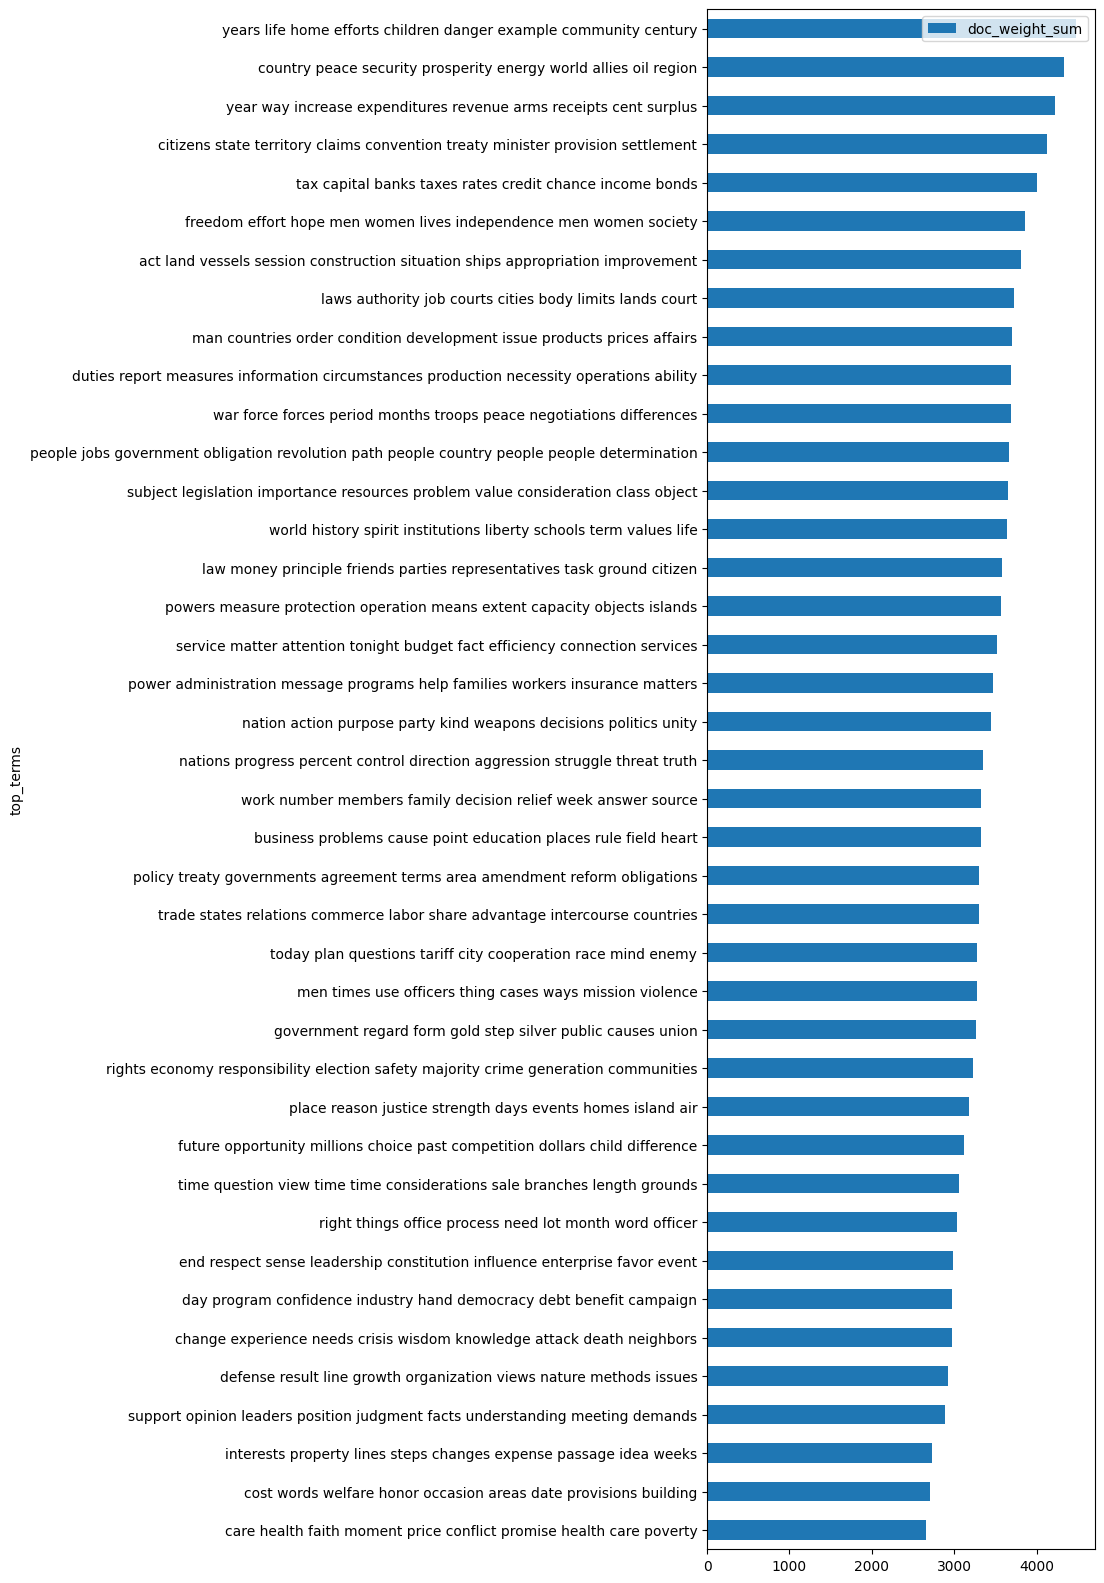

In [116]:
TOPICS.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='top_terms', figsize=(5, n_topics/2));


In [142]:
TOPICS.sort_values('doc_weight_sum', ascending=False)

top_terms  doc_weight_sum  \
topic_id                                                                      
T06       years life home efforts children danger exampl...     4478.998558   
T16       country peace security prosperity energy world...     4337.812354   
T04       year way increase expenditures revenue arms re...     4225.641413   
T10       citizens state territory claims convention tre...     4126.661523   
T39       tax capital banks taxes rates credit chance in...     4010.247723   
T38       freedom effort hope men women lives independen...     3857.882771   
T05       act land vessels session construction situatio...     3806.325453   
T23       laws authority job courts cities body limits l...     3720.535658   
T36       man countries order condition development issu...     3700.907344   
T28       duties report measures information circumstanc...     3690.638044   
T32       war force forces period months troops peace ne...     3688.952065   
T02       people jobs government obligation revolution p...     3666.001161   
T30       subject legislation importance resources probl...     3649.606748   
T19       world history spirit institutions liberty scho...     3640.110553   
T01       law money principle friends parties representa...     3585.078668   
T07       powers measure protection operation means exte...     3570.926759   
T31       service matter attention tonight budget fact e...     3516.173731   
T29       power administration message programs help fam...     3475.879342   
T27       nation action purpose party kind weapons decis...     3443.776448   
T25       nations progress percent control direction agg...     3354.987531   
T17       work number members family decision relief wee...     3323.134282   
T22       business problems cause point education places...     3321.148965   
T15       policy treaty governments agreement terms area...     3306.276339   
T37       trade states relations commerce labor share ad...     3304.789067   
T08       today plan questions tariff city cooperation r...     3282.084403   
T34       men times use officers thing cases ways missio...     3277.900314   
T26       government regard form gold step silver public...     3261.099525   
T09       rights economy responsibility election safety ...     3231.115192   
T00       place reason justice strength days events home...     3182.313675   
T11       future opportunity millions choice past compet...     3116.102235   
T13       time question view time time considerations sa...     3052.622485   
T33       right things office process need lot month wor...     3039.097724   
T14       end respect sense leadership constitution infl...     2985.660039   
T12       day program confidence industry hand democracy...     2974.918955   
T35       change experience needs crisis wisdom knowledg...     2969.245763   
T20       defense result line growth organization views ...     2925.750057   
T24       support opinion leaders position judgment fact...     2891.244792   
T18       interests property lines steps changes expense...     2733.892579   
T03       cost words welfare honor occasion areas date p...     2706.072680   
T21       care health faith moment price conflict promis...     2654.387084   

          term_freq  abraham lincoln  andrew jackson  andrew johnson  \
topic_id                                                               
T06        0.031243         0.020275        0.013134        0.015439   
T16        0.033070         0.023600        0.021804        0.020312   
T04        0.033546         0.038701        0.026146        0.031257   
T10        0.039262         0.058468        0.063985        0.036286   
T39        0.033376         0.014914        0.035367        0.016803   
T38        0.027817         0.014442        0.012121        0.012463   
T05        0.034158         0.039968        0.036040        0.031650   
T23        0.033805         0.042417        0.044905        0.078023   
T36        

In [117]:
pca_engine_phi = PCA(2)

In [118]:
THETA

T00       T01       T02       T03       T04  \
speech_id sent_num                                                     
0         0         0.002778  0.002778  0.002778  0.002778  0.002778   
          1         0.073761  0.001389  0.001389  0.076574  0.001389   
          2         0.002083  0.002083  0.002083  0.002083  0.002083   
          3         0.004167  0.004167  0.004167  0.004167  0.004167   
          4         0.085417  0.168750  0.002083  0.002083  0.002083   
...                      ...       ...       ...       ...       ...   
990       537       0.012500  0.012500  0.012500  0.012500  0.012500   
          539       0.012500  0.012500  0.012500  0.012500  0.012500   
          540       0.025000  0.025000  0.025000  0.025000  0.025000   
          541       0.012500  0.012500  0.012500  0.012500  0.012500   
          542       0.025000  0.025000  0.025000  0.025000  0.025000   

                         T05       T06       T07       T08       T09  ...  \
speech_id sent_num                                                    ...   
0         0         0.002778  0.113889  0.113893  0.002778  0.002778  ...   
          1         0.001389  0.062829  0.001389  0.001389  0.001389  ...   
          2         0.002083  0.002083  0.168750  0.002083  0.002083  ...   
          3         0.004167  0.004167  0.317114  0.004167  0.004167  ...   
          4         0.002083  0.002083  0.002083  0.002083  0.002083  ...   
...                      ...       ...       ...       ...       ...  ...   
990       537       0.012500  0.012500  0.012500  0.012500  0.012500  ...   
          539       0.012500  0.012500  0.012500  0.012500  0.012500  ...   
          540       0.025000  0.025000  0.025000  0.025000  0.025000  ...   
          541       0.012500  0.012500  0.012500  0.512500  0.012500  ...   
          542       0.025000  0.025000  0.025000  0.025000  0.025000  ...   

                         T30       T31       T32       T33       T34  \
speech_id sent_num                                                     
0         0         0.002778  0.002778  0.002778  0.225000  0.002778   
          1         0.001389  0.001389  0.001389  0.112500  0.001389   
          2         0.002083  0.002083  0.002083  0.002083  0.002083   
          3         0.004167  0.191188  0.004167  0.004167  0.004167   
          4         0.085417  0.002083  0.002083  0.002083  0.002083   
...                      ...       ...       ...       ...       ...   
990       537       0.012500  0.012500  0.012500  0.012500  0.012500   
          539       0.012500  0.012500  0.012500  0.012500  0.012500   
          540       0.025000  0.025000  0.025000  0.025000  0.025000   
          541       0.012500  0.012500  0.012500  0.012500  0.012500   
          542       0.025000  0.025000  0.025000  0.025000  0.025000   

                         T35       T36       T37       T38       T39  
speech_id sent_num                                                    
0         0         0.002778  0.113885  0.002778  0.002778  0.002778  
          1         0.066418  0.001389  0.001389  0.056944  0.001389  
          2         0.002083  0.002083  0.002083  0.002083  0.002083  
          3         0.004167  0.004167  0.004167  0.004167  0.004167  
          4         0.085417  0.002083  0.085417  0.085417  0.002083  
...                      ...       ...       ...       ...       ...  
990       537       0.012500  0.512500  0.012500  0.012500  0.012500  
          539       0.012500  0.012500  0.012500  0.012500  0.012500  
          540       0.025000  0.025000  0.025000  0.025000  0.025000  
          541       0.012500  0.012500  0.012500  0.012500  0.012500  
          542       0.025000  0.025000  0.025000  0.025000  0.025000  

[137086 rows x 40 columns]

In [119]:
LIB['president_key'] = LIB.President.str.split(', ').str[0].str.lower()


In [120]:
LIB

Date          President         Party  \
speech_id                                                
0          1789-04-30  George Washington  Unaffiliated   
1          1789-10-03  George Washington  Unaffiliated   
2          1790-01-08  George Washington  Unaffiliated   
3          1790-12-08  George Washington  Unaffiliated   
4          1790-12-29  George Washington  Unaffiliated   
...               ...                ...           ...   
987        2019-01-19       Donald Trump    Republican   
988        2019-02-05       Donald Trump    Republican   
989        2019-02-15       Donald Trump    Republican   
990        2019-09-24       Donald Trump    Republican   
991        2019-09-25       Donald Trump    Republican   

                                                Speech Title  \
speech_id                                                      
0                                    First Inaugural Address   
1                                  Thanksgiving Proclamation   
2                           First Annual Message to Congress   
3                          Second Annual Message to Congress   
4          Talk to the Chiefs and Counselors of the Senec...   
...                                                      ...   
987                     Remarks about the US Southern Border   
988                               State of the Union Address   
989                    Speech Declaring a National Emergency   
990           Remarks at the United Nations General Assembly   
991                                         Press Conference   

               president_key  
speech_id                     
0          george washington  
1          george washington  
2          george washington  
3          george washington  
4          george washington  
...                      ...  
987             donald trump  
988             donald trump  
989             donald trump  
990             donald trump  
991             donald trump  

[991 rows x 5 columns]

In [124]:
PRESIDENTS = sorted(LIB.president_key.value_counts().index.to_list())


In [125]:
TOPICS[PRESIDENTS] = THETA.join(LIB, on='speech_id').groupby('president_key')[TNAMES].mean().T


In [126]:
TOPICS

top_terms  doc_weight_sum  \
topic_id                                                                      
T00       place reason justice strength days events home...     3182.313675   
T01       law money principle friends parties representa...     3585.078668   
T02       people jobs government obligation revolution p...     3666.001161   
T03       cost words welfare honor occasion areas date p...     2706.072680   
T04       year way increase expenditures revenue arms re...     4225.641413   
T05       act land vessels session construction situatio...     3806.325453   
T06       years life home efforts children danger exampl...     4478.998558   
T07       powers measure protection operation means exte...     3570.926759   
T08       today plan questions tariff city cooperation r...     3282.084403   
T09       rights economy responsibility election safety ...     3231.115192   
T10       citizens state territory claims convention tre...     4126.661523   
T11       future opportunity millions choice past compet...     3116.102235   
T12       day program confidence industry hand democracy...     2974.918955   
T13       time question view time time considerations sa...     3052.622485   
T14       end respect sense leadership constitution infl...     2985.660039   
T15       policy treaty governments agreement terms area...     3306.276339   
T16       country peace security prosperity energy world...     4337.812354   
T17       work number members family decision relief wee...     3323.134282   
T18       interests property lines steps changes expense...     2733.892579   
T19       world history spirit institutions liberty scho...     3640.110553   
T20       defense result line growth organization views ...     2925.750057   
T21       care health faith moment price conflict promis...     2654.387084   
T22       business problems cause point education places...     3321.148965   
T23       laws authority job courts cities body limits l...     3720.535658   
T24       support opinion leaders position judgment fact...     2891.244792   
T25       nations progress percent control direction agg...     3354.987531   
T26       government regard form gold step silver public...     3261.099525   
T27       nation action purpose party kind weapons decis...     3443.776448   
T28       duties report measures information circumstanc...     3690.638044   
T29       power administration message programs help fam...     3475.879342   
T30       subject legislation importance resources probl...     3649.606748   
T31       service matter attention tonight budget fact e...     3516.173731   
T32       war force forces period months troops peace ne...     3688.952065   
T33       right things office process need lot month wor...     3039.097724   
T34       men times use officers thing cases ways missio...     3277.900314   
T35       change experience needs crisis wisdom knowledg...     2969.245763   
T36       man countries order condition development issu...     3700.907344   
T37       trade states relations commerce labor share ad...     3304.789067   
T38       freedom effort hope men women lives independen...     3857.882771   
T39       tax capital banks taxes rates credit chance in...     4010.247723   

          term_freq  abraham lincoln  andrew jackson  andrew johnson  \
topic_id                                                               
T00        0.021341         0.024242        0.019095        0.020891   
T01        0.027425         0.030645        0.043991        0.043079   
T02        0.026207         0.021588        0.020330        0.022792   
T03        0.017849         0.019095        0.019074        0.019550   
T04        0.033546         0.038701        0.026146        0.031257   
T05        0.034158         0.039968        0.036040        0.031650   
T06        0.031243         0.020275        0.013134        0.015439   
T07        0.028952         0.032305        0.045525        0.030014   
T08        

In [127]:
TOPICS['president'] = TOPICS[PRESIDENTS].idxmax(1)
TOPICS['label'] = TOPICS.president.str.upper() + ' ' + TOPICS.index + ' ' + TOPICS.top_terms

In [129]:
TOPICS.to_csv('TOPICS.csv')

In [130]:
TOPICS

top_terms  doc_weight_sum  \
topic_id                                                                      
T00       place reason justice strength days events home...     3182.313675   
T01       law money principle friends parties representa...     3585.078668   
T02       people jobs government obligation revolution p...     3666.001161   
T03       cost words welfare honor occasion areas date p...     2706.072680   
T04       year way increase expenditures revenue arms re...     4225.641413   
T05       act land vessels session construction situatio...     3806.325453   
T06       years life home efforts children danger exampl...     4478.998558   
T07       powers measure protection operation means exte...     3570.926759   
T08       today plan questions tariff city cooperation r...     3282.084403   
T09       rights economy responsibility election safety ...     3231.115192   
T10       citizens state territory claims convention tre...     4126.661523   
T11       future opportunity millions choice past compet...     3116.102235   
T12       day program confidence industry hand democracy...     2974.918955   
T13       time question view time time considerations sa...     3052.622485   
T14       end respect sense leadership constitution infl...     2985.660039   
T15       policy treaty governments agreement terms area...     3306.276339   
T16       country peace security prosperity energy world...     4337.812354   
T17       work number members family decision relief wee...     3323.134282   
T18       interests property lines steps changes expense...     2733.892579   
T19       world history spirit institutions liberty scho...     3640.110553   
T20       defense result line growth organization views ...     2925.750057   
T21       care health faith moment price conflict promis...     2654.387084   
T22       business problems cause point education places...     3321.148965   
T23       laws authority job courts cities body limits l...     3720.535658   
T24       support opinion leaders position judgment fact...     2891.244792   
T25       nations progress percent control direction agg...     3354.987531   
T26       government regard form gold step silver public...     3261.099525   
T27       nation action purpose party kind weapons decis...     3443.776448   
T28       duties report measures information circumstanc...     3690.638044   
T29       power administration message programs help fam...     3475.879342   
T30       subject legislation importance resources probl...     3649.606748   
T31       service matter attention tonight budget fact e...     3516.173731   
T32       war force forces period months troops peace ne...     3688.952065   
T33       right things office process need lot month wor...     3039.097724   
T34       men times use officers thing cases ways missio...     3277.900314   
T35       change experience needs crisis wisdom knowledg...     2969.245763   
T36       man countries order condition development issu...     3700.907344   
T37       trade states relations commerce labor share ad...     3304.789067   
T38       freedom effort hope men women lives independen...     3857.882771   
T39       tax capital banks taxes rates credit chance in...     4010.247723   

          term_freq  abraham lincoln  andrew jackson  andrew johnson  \
topic_id                                                               
T00        0.021341         0.024242        0.019095        0.020891   
T01        0.027425         0.030645        0.043991        0.043079   
T02        0.026207         0.021588        0.020330        0.022792   
T03        0.017849         0.019095        0.019074        0.019550   
T04        0.033546         0.038701        0.026146        0.031257   
T05        0.034158         0.039968        0.036040        0.031650   
T06        0.031243         0.020275        0.013134        0.015439   
T07        0.028952         0.032305        0.045525        0.030014   
T08        

## LDA + PCA Visualization 

In [128]:
from sklearn.preprocessing import normalize

PHI_COMPS = pd.DataFrame(pca_engine_phi.fit_transform(normalize(PHI, norm='l2', axis=1)), index=PHI.index)
px.scatter(PHI_COMPS.reset_index(), 0, 1, 
           size=TOPICS.doc_weight_sum, 
           color=TOPICS.president, 
           text='topic_id', hover_name=TOPICS.label, height=600, width=700)


## Sentiment VOCAB_SENT

In [146]:
salex_csv= 'C:/Users/bigja/OneDrive/Documents/DS5001/data/presidential_speeches/salex_nrc.csv'
salex = pd.read_csv(salex_csv).set_index('term_str')
salex.columns = [col.replace('nrc_','') for col in salex.columns]

In [147]:
LIB['title_short'] = LIB.President + ':'+LIB.index.astype('str') + ': ' + LIB['Speech Title'].str[:25] 

In [148]:
LIB

Date          President         Party  \
speech_id                                                
0          1789-04-30  George Washington  Unaffiliated   
1          1789-10-03  George Washington  Unaffiliated   
2          1790-01-08  George Washington  Unaffiliated   
3          1790-12-08  George Washington  Unaffiliated   
4          1790-12-29  George Washington  Unaffiliated   
...               ...                ...           ...   
987        2019-01-19       Donald Trump    Republican   
988        2019-02-05       Donald Trump    Republican   
989        2019-02-15       Donald Trump    Republican   
990        2019-09-24       Donald Trump    Republican   
991        2019-09-25       Donald Trump    Republican   

                                                Speech Title  \
speech_id                                                      
0                                    First Inaugural Address   
1                                  Thanksgiving Proclamation   
2                           First Annual Message to Congress   
3                          Second Annual Message to Congress   
4          Talk to the Chiefs and Counselors of the Senec...   
...                                                      ...   
987                     Remarks about the US Southern Border   
988                               State of the Union Address   
989                    Speech Declaring a National Emergency   
990           Remarks at the United Nations General Assembly   
991                                         Press Conference   

               president_key                                     title_short  
speech_id                                                                     
0          george washington    George Washington:0: First Inaugural Address  
1          george washington  George Washington:1: Thanksgiving Proclamation  
2          george washington  George Washington:2: First Annual Message to C  
3          george washington  George Washington:3: Second Annual Message to   
4          george washington  George Washington:4: Talk to the Chiefs and Co  
...                      ...                                             ...  
987             donald trump     Donald Trump:987: Remarks about the US Sout  
988             donald trump     Donald Trump:988: State of the Union Addres  
989             donald trump     Donald Trump:989: Speech Declaring a Nation  
990             donald trump     Donald Trump:990: Remarks at the United Nat  
991             donald trump              Donald Trump:991: Press Conference  

[991 rows x 6 columns]

In [151]:
V_sa= pd.concat([VOCAB.reset_index().set_index('term_str'), salex], join='inner', axis=1)


In [152]:
V_sa

n  n_chars             p          i max_pos  n_pos  \
term_str                                                            
abandon      170        7  4.429036e-05  14.462648      VB      8   
abandoned    132        9  3.439016e-05  14.827645     VBN      4   
abandonment   61       11  1.589242e-05  15.941301      NN      2   
abduction      1        9  2.605315e-07  21.872039      NN      1   
aberration     2       10  5.210631e-07  20.872039      NN      1   
...          ...      ...           ...        ...     ...    ...   
young        858        5  2.235361e-04  12.127205      JJ      3   
youth        124        5  3.230591e-05  14.917842      NN      5   
zeal         118        4  3.074272e-05  14.989396      NN      1   
zealous       34        7  8.858072e-06  16.784576      JJ      1   
zest           3        4  7.815946e-07  20.287076      NN      2   

                                         cat_pos  stop stem_porter  \
term_str                                                             
abandon      {VBP, NNS, VB, RB, NN, JJ, VBZ, IN}     0     abandon   
abandoned                    {VBD, JJ, NNP, VBN}     0     abandon   
abandonment                             {JJ, NN}     0     abandon   
abduction                                   {NN}     0      abduct   
aberration                                  {NN}     0       aberr   
...                                          ...   ...         ...   
young                              {NN, JJ, NNP}     0       young   
youth                      {VB, RB, NN, JJ, NNP}     0       youth   
zeal                                        {NN}     0        zeal   
zealous                                     {JJ}     0      zealou   
zest                                   {NN, JJS}     0        zest   

            stem_snowball  ... anticipation  disgust  fear  joy  negative  \
term_str                   ...                                              
abandon           abandon  ...            0        0     1    0         1   
abandoned         abandon  ...            0        0     1    0         1   
abandonment       abandon  ...            0        0     1    0         1   
abduction          abduct  ...            0        0     1    0         1   
aberration          aberr  ...            0        1     0    0         1   
...                   ...  ...          ...      ...   ...  ...       ...   
young               young  ...            1        0     0    1         0   
youth               youth  ...            1        0     1    1         0   
zeal                 zeal  ...            1        0     0    1         0   
zealous           zealous  ...            0        0     0    1         0   
zest                 zest  ...            1        0     0    1         0   

             positive  sadness  surprise  trust  sentiment  
term_str                                                    
abandon             0        1         0      0         -1  
abandoned           0        1         0      0         -1  
abandonment         0        1         1      0         -1  
abduction           0        1         1      0         -1  
aberration          0        0         0      0         -1  
...               ...      ...       ...    ...        ...  
young               1        0         1      0          1  
youth               1        0         1      0          1  
zeal                1        0         1      1          1  
zealous             1        0         0      1          1  
zest                1        0         0      1          1  

[2939 rows x 23 columns]

In [154]:
V_sa.to_csv('VOCAB_SENT.csv')

## Sentiment BOW_SENT

In [156]:
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()


In [157]:
B = BOW.join(V_sa[['max_pos'] + emo_cols], on='term_str', rsuffix='_v').dropna()


In [158]:
for col in emo_cols:
    B[col] = B[col] * B.tfidf

In [161]:
B = B.join(LIB['president_key'], on='speech_id')

In [162]:
B

n     tfidf max_pos     anger  anticipation  disgust  \
speech_id term_str                                                             
0         accomplished  1  0.017435     VBN  0.000000      0.000000      0.0   
          adore         1  0.067972      RB  0.000000      0.067972      0.0   
          appreciation  1  0.029176      NN  0.000000      0.000000      0.0   
          ardent        1  0.041952      JJ  0.000000      0.041952      0.0   
          asylum        1  0.043978      NN  0.000000      0.000000      0.0   
...                    ..       ...     ...       ...           ...      ...   
990       word          3  0.030211      NN  0.000000      0.000000      0.0   
          words         3  0.019291     NNS  0.019291      0.000000      0.0   
          worried       1  0.023574      JJ  0.000000      0.000000      0.0   
          worse         2  0.026429     JJR  0.000000      0.000000      0.0   
          young         1  0.006852      JJ  0.000000      0.006852      0.0   

                            fear       joy   sadness  surprise     trust  \
speech_id term_str                                                         
0         accomplished  0.000000  0.017435  0.000000  0.000000  0.000000   
          adore         0.000000  0.067972  0.000000  0.000000  0.067972   
          appreciation  0.000000  0.029176  0.000000  0.000000  0.029176   
          ardent        0.000000  0.041952  0.000000  0.000000  0.000000   
          asylum        0.043978  0.000000  0.000000  0.000000  0.000000   
...                          ...       ...       ...       ...       ...   
990       word          0.000000  0.000000  0.000000  0.000000  0.030211   
          words         0.000000  0.000000  0.000000  0.000000  0.000000   
          worried       0.000000  0.000000  0.023574  0.000000  0.000000   
          worse         0.026429  0.000000  0.026429  0.000000  0.000000   
          young         0.000000  0.006852  0.000000  0.006852  0.000000   

                        sentiment      president_key  
speech_id term_str                                    
0         accomplished   0.017435  george washington  
          adore          0.067972  george washington  
          appreciation   0.029176  george washington  
          ardent         0.041952  george washington  
          asylum        -0.043978  george washington  
...                           ...                ...  
990       word           0.030211       donald trump  
          words         -0.019291       donald trump  
          worried       -0.023574       donald trump  
          worse         -0.026429       donald trump  
          young          0.006852       donald trump  

[128756 rows x 13 columns]

In [159]:
B.to_csv('BOW_SENT.csv')

## Sentiment DOC_SENT

In [166]:
EMO_speech = B.groupby(['speech_id'])[emo_cols].mean()


In [168]:
EMO_speech.to_csv('DOC_SENT.csv')

In [171]:
EMO_speech = EMO_speech.join(LIB['Date'], on='speech_id')

In [174]:
EMO_speech['Date'] = pd.to_datetime(EMO_speech['Date'])

EMO_speech['Year'] = EMO_speech['Date'].dt.year

In [175]:
EMO_speech.head()

anger  anticipation   disgust      fear       joy   sadness  \
speech_id                                                                   
0          0.002476      0.009795  0.002363  0.004192  0.012971  0.004627   
1          0.000000      0.020572  0.006779  0.006283  0.022020  0.004601   
2          0.004509      0.012280  0.001491  0.004595  0.009829  0.002754   
3          0.004931      0.006046  0.001388  0.005593  0.009307  0.005733   
4          0.009751      0.007933  0.009766  0.010647  0.008127  0.011349   

           surprise     trust  sentiment       Date    Year  
speech_id                                                    
0          0.002340  0.015785   0.016232 1789-04-30  1789.0  
1          0.003373  0.045926   0.050310 1789-10-03  1789.0  
2          0.002870  0.020134   0.022319 1790-01-08  1790.0  
3          0.002708  0.012691   0.008032 1790-12-08  1790.0  
4          0.003437  0.015781   0.000795 1790-12-29  1790.0

## Sentiment Plot

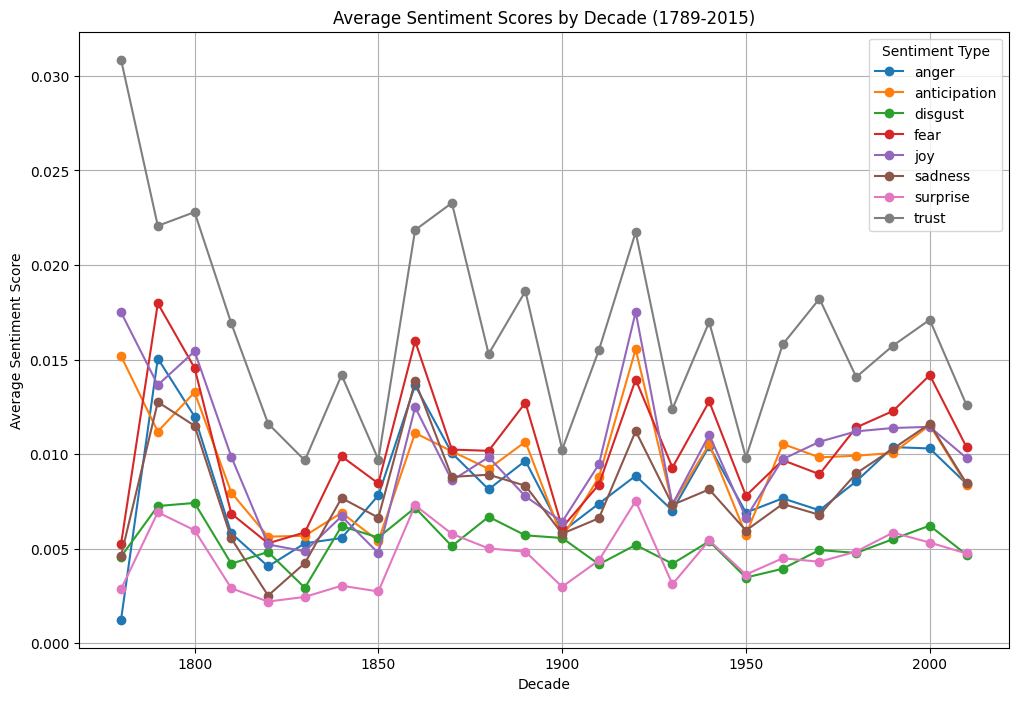

In [184]:
import matplotlib.ticker as ticker

import matplotlib.pyplot as plt

# Grouping by decade
EMO_speech['Decade'] = (EMO_speech['Year'] // 10) * 10

# Calculating mean sentiment scores per decade
decade_means = EMO_speech.groupby('Decade').mean()

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
for column in decade_means.columns[:-3]:  # Exclude the 'Year' column
    ax.plot(decade_means.index, decade_means[column], label=column, marker='o')

ax.set_title('Average Sentiment Scores by Decade (1789-2015)')
ax.set_xlabel('Decade')
ax.set_ylabel('Average Sentiment Score')
ax.legend(title='Sentiment Type')
plt.grid(True)
plt.show()